<h1>Digitizing flower images to polygons</h1>

<a id='dougOut'><h3>Getting images out of Doug's raster pipeline</h3></a>

Let's dive back into the process of making polygons from Doug's processed photos. Flower photos were broken into their various petals of interest, and color differences were maximized by categorizing all pixels into three color poles using kmeans clustering. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

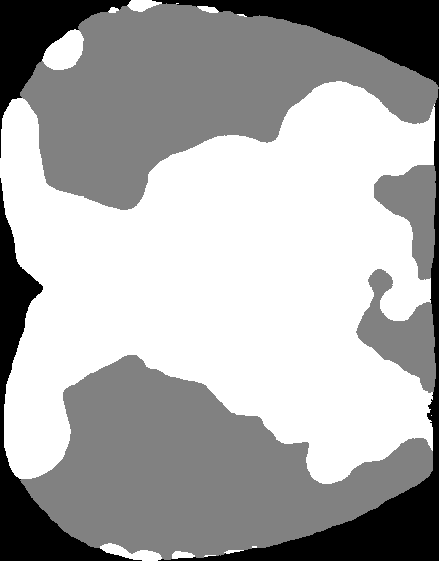

In [1]:
load("../dougRaster/Rotated_and_Cropped/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

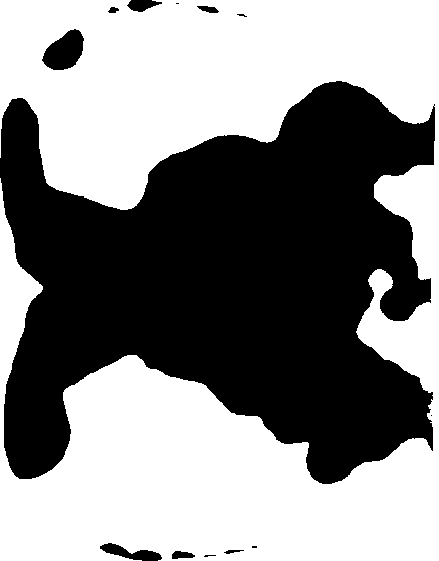

In [2]:
bb = aa < 1;
imshow(bb);


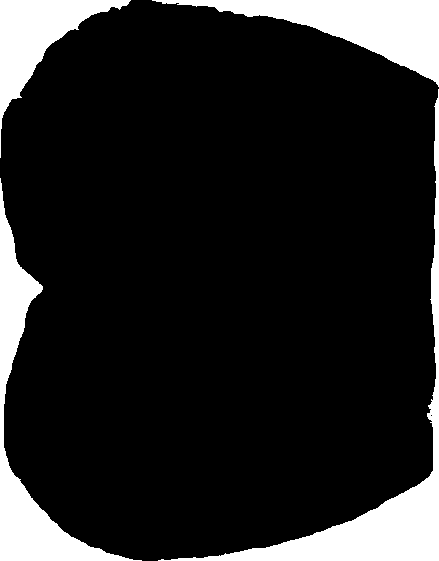

In [3]:
cc = aa == 0;
imshow(cc);

We can generalize the above process, to get all of the available photos from Doug's efforts into a form ready to digitized. I wrote a matlab script for this:

In [1]:
cat prepDougRasters.m

%%%%%%%%%%%%%%%%%%%%%%%%%%

%% a script to put all of Doug's rasters into a form we can use:

%% go to working directory
wd = '/Users/danthomas/Documents/speckling/make_polygons/polygons/';
cd(wd);

dougRasterDir = "/Users/danthomas/Documents/speckling/dougRaster/Rotated_and_Cropped/";

cd(dougRasterDir)

files = dir('P*.mat');
for file = files';
    im = file.name;
    imName = regexprep(im,'\.mat', ''); 
    %% go get our file, come back
    cd(dougRasterDir);
    rast=load(im);
    cd(wd);
    %% make a spot for our image, go to it:
    mkdir(imName);
    cd (imName);
    %% get our petal names (left, right mid)
    petNames = fieldnames(rast.Petals.Clusters);
    %% split images into petal and spot, export, for each of the three petals:
    for i = 1:length(petNames);
        pet = rast.Petals.Clusters.(petNames{i}); %petal at hand
        rastGray = mat2gray(pet); 
        spots = rastGray  < 1; 
        petal = rastGray == 0;
        mkdir(petNames{i});
        cd(petNames{i});
 

This is brittle code, if the file architecture of the repo or the shape of Doug's matlab structures changes, it will break. But most of it should be useful/re-useable, so including it here. 

<a id='skimmage'><h3>Digitizing with scikit-image</h3></a>

Let's see if a quick dip into python, in particular [scikit-image](https://scikit-image.org/), can help us. And [shapely](toblerity.org/shapely/manual.html), the standard package for manipulating polygons in python. 

In [6]:
import argparse, os, pickle
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.affinity as sa
import matplotlib.image as mpimg
from skimage import measure
from descartes import PolygonPatch

<h5><a id='getPolys'>Get petal and spot polygons</a></h5>

In python, let's get the petal and spots from these images, by tracing their outlines.

Our first step is to trace the contours of our petals and spots. Here's a function that reads in one of these csvs from Doug, and turns it into a n x 2 array that can be used as polygon vertices, useful for petal or spots:

In [11]:
def digitizePols(file):
    """pad margins of image and get the contour of the petal shape"""
    petal = np.genfromtxt (file, delimiter=",")
    petal_marg = np.insert(petal, petal.shape[1], 1, 1)
    petal_marg = np.insert(petal_marg, 0, 1, 1)
    petal_marg = np.insert(petal_marg, petal.shape[0], 1, 0)
    petal_marg = np.insert(petal_marg, 0, 1, 0)
    Pcontours = measure.find_contours(petal_marg, 0)
    ## gotta ditch <3 points, they are lines
    polys = [ i for i in Pcontours if len(i) > 3 ]
    return(polys)

We need to look at our raw petal outline first, to create a reference for centering and scaling (standardizing) the petal and spots. This function gets the information (centroid, scaling constant) we need to do that:

In [12]:
def getPetGeoInfo(pet):
    """get centroid and scaling factor needed to standardize petals and spots"""
    aa = sg.asPolygon(pet)
    area = aa.area
    scalar = area**(-1/2)
    center = aa.centroid
    centerCoor = (center.x, center.y)
    return(scalar, centerCoor)

With this info, we can craft a function to "standardize" our petals and our spots. In our case, that means center the petal and the array of spots to the origin, scale the petal polygon to area =1, and scale the spots by this same ratio:

In [13]:
def stand(pol, scale, cent):
    
    aa = sg.asPolygon(pol)
    trans = sa.translate(aa, (-1*cent[0]), (-1*cent[1]))
    scaled = sa.scale(trans, xfact=scale, yfact=scale, origin = (0,0))
    return(scaled)

We can also define three zones of interest - center, margin and petal. We define the proportion ('percent') of petal we would like to remain as "center", and the rest is given to the margin and throat:

In [14]:
def findZones(standPol, percent=0.5, simp=0.05):
    """a function to designate center, throat, and edge zones in our petals"""

    def cleanCollections(geo):
        """sometimes our digitizing creates smatterings of geometries instead 
        of a single clean polygon. This attempts to prune down to the main polygon,
        which is usually the object we want."""
        if type(geo) is not sg.polygon.Polygon:
            if type(geo) is sg.collection.GeometryCollection:
                onlyPolys = [ i for i in geo if type(i) == sg.polygon.Polygon ]
            else:
                onlyPolys = geo
            areas = [ i.area for i in onlyPolys ]
            biggestPoly = [ i for i in onlyPolys if i.area == max(areas) ][0]
            return(biggestPoly)
        elif type(geo) is sg.polygon.Polygon:
            return(geo)

    ## build a buffer, starting from the petal edge and 
    ## creeping inward until percent area is reached.
    center = standPol
    rad = 0
    while center.area > percent:
        center = standPol.buffer(rad)
        rad -= .001
    marg = sg.polygon.Polygon(
            standPol.exterior,
            holes = [center.exterior.coords])
    
    ## break up margin into edge and throat:
    simPol = marg.simplify(simp)
    simPolA = np.array(simPol.exterior.xy).transpose()
    simPolAsorted = simPolA[simPolA[:,1].argsort()[::-1]]
    outCorners = simPolAsorted[0:2]
    simPolB = np.array(simPol.interiors[0].xy).transpose()
    simPolBsorted = simPolB[simPolB[:,1].argsort()[::-1]]
    inCorners = simPolBsorted[0:2,]
    inCorners = np.flipud(inCorners)
    tRap = np.concatenate((outCorners,inCorners))
    tRapPoly = sg.polygon.Polygon(tRap)
    
    ## polygon calculations start here, risky:
    try:
        tBuff = tRapPoly.buffer(0.1)
        noTrap = marg.difference(tRapPoly)
        notInTrap = [ i for i in noTrap if i.within(tBuff) ]
        mpNotInTrap = sg.multipolygon.MultiPolygon(notInTrap)
        margInTrap = tRapPoly.intersection(marg)
        throatRaw = margInTrap.union(mpNotInTrap )
        throat = cleanCollections(throatRaw)
        edgeRaw = marg.difference(throat)
        edge = cleanCollections(edgeRaw)
    except:
        ## if they don't work..
        ## use the margin for edge
        edge = marg
        ## throat will be empty
        throat = sg.polygon.Polygon()
        print('Throat calculations failed. '
              'Throat will be empty and Edge will '
              'consist of entire margin.')
    finally:
        return(center, edge, throat)



There is a lot going on in that function. The local function inside tries to clean up small junk geometries created by our petal/spot digitizing and our throat/edge separation. The while loop grows an inward buffer polygon ("margin") that will become our edge and throat. 

The following separation of margin into edge and throat are dependent on the [simplification method of polygons in shapely](http://toblerity.org/shapely/manual.html#object.simplify). Using this we harden the lines of the polygon according to the "simp" parameter of the function. This results in fewer vertices and we pick the top two vertices in our petal outline and in our margin to delineate the four corners of the throat. This works as a first guess but fails often for finding the throat/edge. So if time allows we'll build in a manual correction/sanity check into this pipeline. 

Also on the todo list is the handling of errors, here and elsewhere I have mostly left them blank in my hurry to get some results to play with. If any of this data turns out to be useful, some exception types will have to be defined. 

While we're here, let's make a function for plotting the results:

In [15]:
def pZones(standPet, spotz, center, edge, throat):

    fig, (ax1,ax2) = plt.subplots(ncols=2)

    ## just petal and spots
    xs, ys = standPet.exterior.xy
    ax1.fill(xs, ys, "y")
    for i in spotz:
        xs, ys = i.exterior.xy
        ax1.fill(xs, ys, "r")
     
    ## second image, with zones
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    xs, ys = standPet.exterior.xy
    ax2.fill(xs, ys, "y")
    for i in spotz:
        xs, ys = i.exterior.xy
        ax2.fill(xs, ys, "r")
    alp=0.5
    l=5
    ax2.add_patch(PolygonPatch(center,
                  fc='white', ec='black',
                  linewidth=l, alpha=alp))
    ax2.add_patch(PolygonPatch(throat,
                  fc='white', ec='black',
                  linewidth=l, alpha=alp))
    ax2.add_patch(PolygonPatch(edge,
                  fc='white', ec='black',
                  linewidth=l, alpha=alp))

With these functions, we can take the petal and spots from doug's rasters and make some standardized petal and spot polygons:

In [15]:
## we have an example "right" or lower petal example in our wd:
petalFile=('P431F1petal.csv')
spotsFile=('P431F1spots.csv')

## 1 make our raw, unscaled, untranslated polygons:
testP = digitizePols(petalFile)[0] ## for petals, take first polygon, always seems to work?
testS = digitizePols(spotsFile)

## 2 get information about centroid and scaling factor:
scale, cent = getPetGeoInfo(testP)

## 3 standardize petals
standPet = stand(testP, scale, cent)

## 4 standardize spots
spotz = [ stand(i, scale, cent) for i in testS ]

## 5 define zones, at 50%:
center, edge, throat = findZones(standPet, 0.5, 0.7)

Did this work?

In [4]:
exFlowerImage="/home/daniel/Documents/mimulusSpeckling/dougRaster/Rotated_and_Cropped/P431F1.JPG"

In [8]:
plt.rcParams['figure.figsize'] = [15, 5]

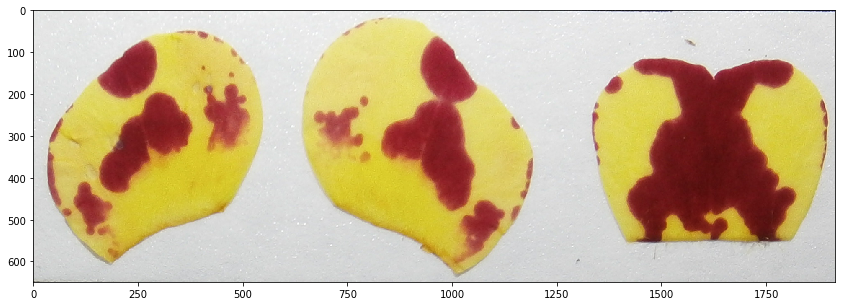

In [9]:
img=mpimg.imread(exFlowerImage)
plt.imshow(img)

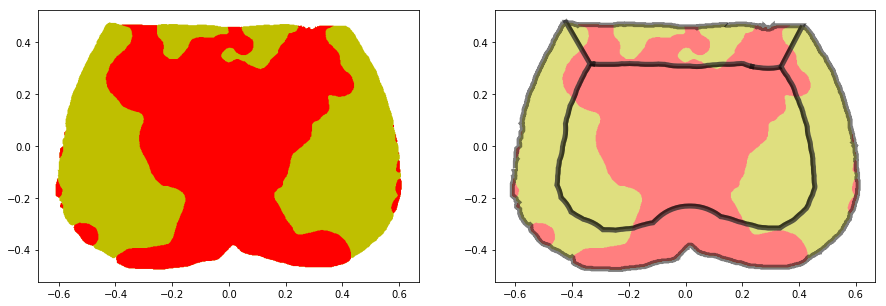

In [16]:
pZones(standPet, spotz, center, edge, throat)

We have a petal area = 1, and petal centroid is on the origin. Zones are coming along. Generally, looks good. But how about our upper petals (doug's "left" and "mid" petals)?

In [18]:
petDir = ("/home/daniel/Documents/mimulusSpeckling/make_polygons/polygons/P431F1/left/")
## this will change for mac, etc.

In [19]:
## dig out the upper left petal:
petalFName=('P431F1_left_petal.csv')
spotsFName=('P431F1_left_spots.csv')
petalFile=(petDir + petalFName)
spotsFile=(petDir + spotsFName)

## run this through our pipeline:

testP = digitizePols(petalFile)[0] 
testS = digitizePols(spotsFile)
scale, cent = getPetGeoInfo(testP)
standPet = stand(testP, scale, cent)
spotz = [ stand(i, scale, cent) for i in testS ]
center, edge, throat = findZones(standPet, 0.5, 0.07)

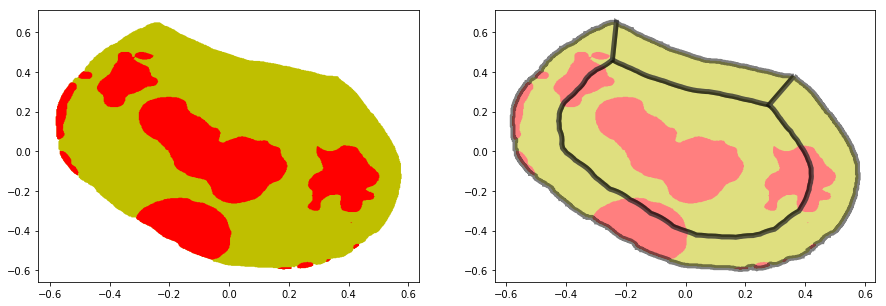

In [20]:
pZones(standPet, spotz, center, edge, throat)

In [23]:
petDir = ("/home/daniel/Documents/mimulusSpeckling/make_polygons/polygons/P431F1/mid/")
## this will change for mac, etc.

In [27]:
## dig out the upper right petal:
petalFName=('P431F1_mid_petal.csv')
spotsFName=('P431F1_mid_spots.csv')
petalFile=(petDir + petalFName)
spotsFile=(petDir + spotsFName)

## run this through our pipeline:

testP = digitizePols(petalFile)[0] 
testS = digitizePols(spotsFile)
scale, cent = getPetGeoInfo(testP)
standPet = stand(testP, scale, cent)
spotz = [ stand(i, scale, cent) for i in testS ]
center, edge, throat = findZones(standPet, percent=0.5, simp=0.05)

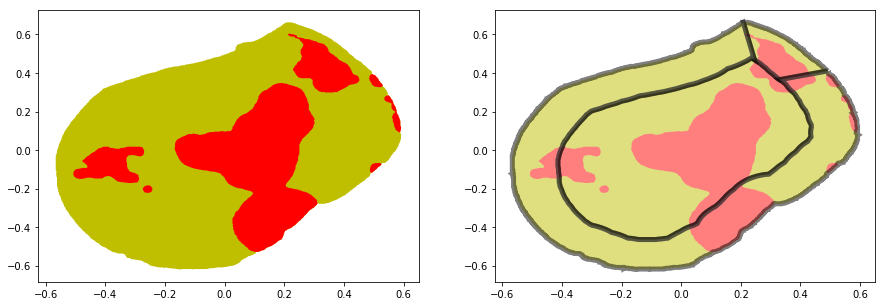

In [28]:
pZones(standPet, spotz, center, edge, throat)

We see that the throat delineation fails. That was with the default simp=0.5 for polygon simplification. Sometimes we can improve things a bit with a harder simplification:

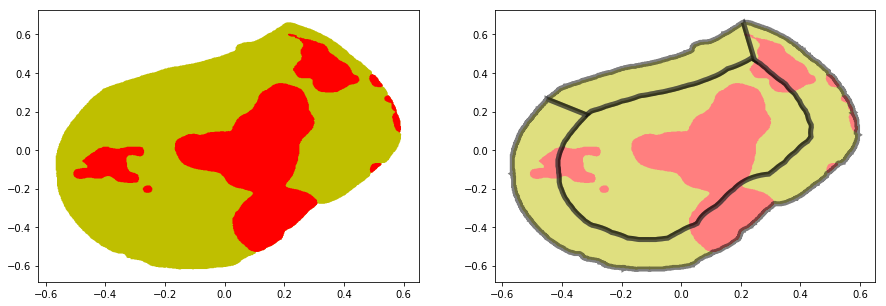

In [31]:
center, edge, throat = findZones(standPet, percent=0.5, simp=0.1)
pZones(standPet, spotz, center, edge, throat)

That worked. So we may need to play with the simplification parameter. The defult settings sometimes work, sometimes not. But in general the throat zones are again a major problem, I think manual correction or some badass machine learning are the only way out...

<h3><a>Applying our digitizing pipeline to all files</a></h3>

To use these functions across all of our flower petals, we have these functions in a module, with a \__main\__ script for applying this. It's in the [github repo](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/get_pols.py), and is used on the command line like this:

So we can run this on one of our black-and-white CSVs that we got from doug's pipeline [(above)](#dougOut). It works on a folder that contains the black-n-white csvs of petals and polygons, named according to Doug's original filename protocol:

`get_pols.py [folder with raster CSVs] [size of center polygon as percentage of petal] [destination folder]` 

A bash script for applying this to my folder of images:

In [ ]:
#!/usr/bin/env bash

getpols='/home/daniel/Documents/mimulusSpeckling/make_polygons/get_pols.py'
wd='/home/daniel/Documents/mimulusSpeckling/make_polygons/polygons'

cd $wd

for i in *; do
    echo $i
    cd $i
    for j in *; do
        fullN=$PWD/$j
        $getpols $fullN 0.5 $fullN
    done
    cd ../
done

<h3><a>Geojson files equal freedom</a></h3>

The result of this pipeline are [geojson](http://geojson.org/) files. They should be viewable and editable in many types of software. If we need it and have time, this will be a convenient way to quality check and correct the spot polygons. With some GIS software like ARCGIS or QGIS, We can break up the petal spots that merged, etc. 

In [36]:
plt.rcParams['figure.figsize'] = [20, 20]

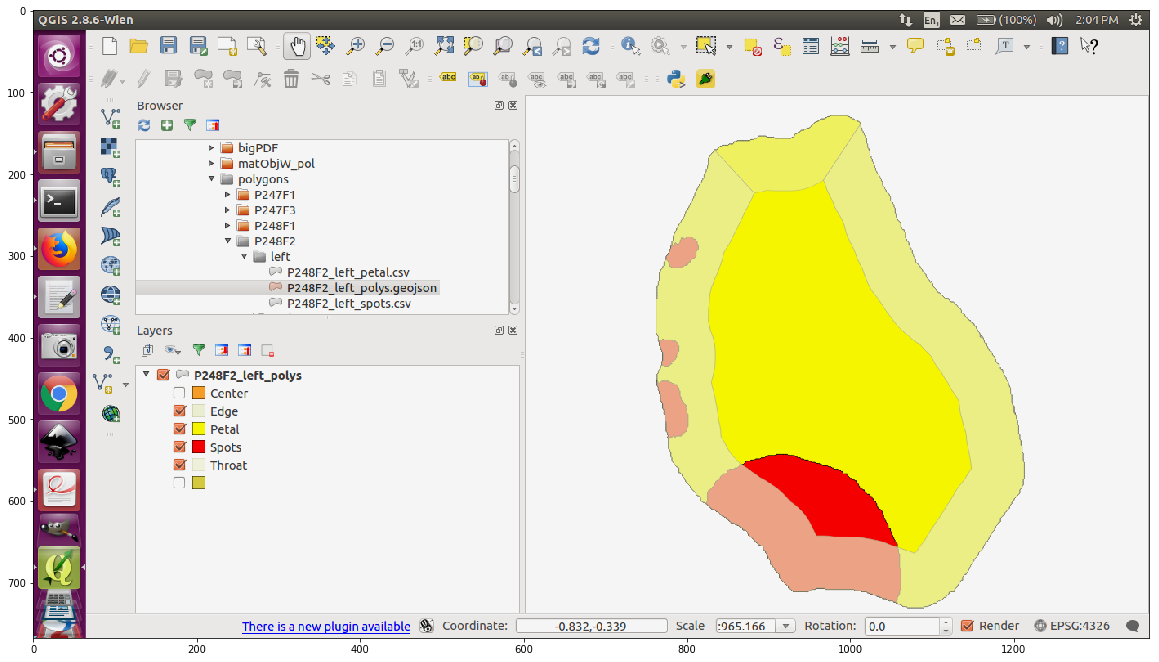

In [37]:
img=mpimg.imread('qGISscreenshot.png')
plt.imshow(img)